In [75]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import backtester_base as q_base
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
db = dm.read_db(base='prices_global.pkl', add=['prices_global_gwx.pkl','prices_kr.pkl'])
db_kr = dm.read_db(base='prices_kr.pkl', add=['prices_global.pkl'])

# Multiasset model

In [13]:
multiasset = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    rebal_style='cum', 
    n_picks=10, 
    assets=setting.assets_multiasset, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], #[1,0,0,0,0,0,1,0,0,0.25*4,0.25*6,0.25*12], #
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=24, 
    follow_trend=None, #(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='BND_US_HY', #'ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_Interm', 
    start='2007-12-31', 
    losscut=0.05, 
    profitake_sigma=3, 
    rentry_sigma=2, 
)

HBox(children=(IntProgress(value=0, max=129), HTML(value='')))


40.0091712474823


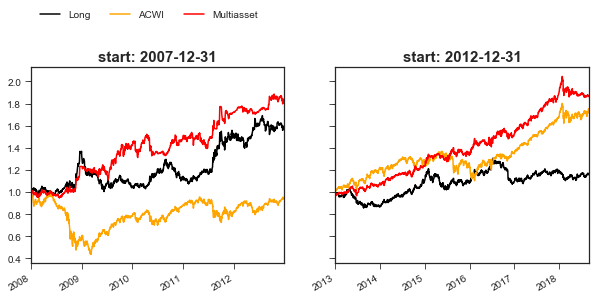

In [14]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'Multiasset']
color = ['k', 'orange', 'r']

multiasset.plot_cum_multi_periods(strats, names=names, color=color, logy=False, separator=['2012-12-31'])

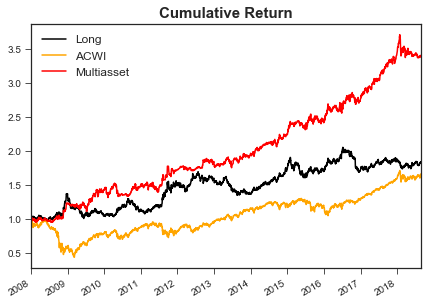

In [15]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'Multiasset']
color = ['k', 'orange', 'r']

multiasset.plot_cum(strats, names=names, color=color, logy=False)

In [16]:
rt = multiasset.cum.DualMomentum.resample('M').ffill().pct_change()
rt[rt<-0.05]

2009-04-30   -0.058353
2010-05-31   -0.083441
2018-02-28   -0.051465
Name: DualMomentum, dtype: float64

In [17]:
multiasset.get_stats().tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_DevIG_loc,1.20,2101,2.23,8.53,0.26,-17.27,2.75,8.42,0.32,0.17,32.83,55.56,1.02,12.75
BND_US_Long,1.82,2688,5.72,14.81,0.39,-26.58,5.51,14.10,0.34,-0.30,29.85,51.97,1.37,85.26
BND_US_IG,1.70,2688,5.06,8.41,0.60,-21.54,6.71,5.74,1.21,0.06,17.38,62.20,1.14,91.43
PrecMetal,1.16,2688,1.43,21.62,0.07,-55.70,-0.31,19.67,-0.02,0.13,50.64,50.39,1.14,-38.20
DualMomentum,3.37,2688,11.98,12.51,0.96,-12.79,13.06,11.83,1.09,0.11,1.03,59.06,1.67,98.19


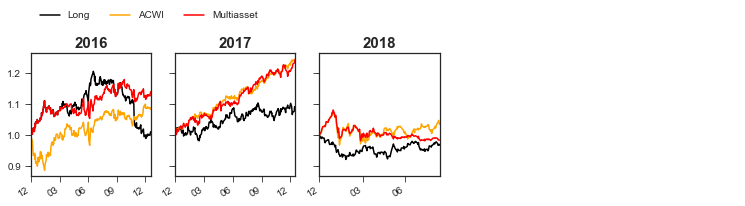

In [18]:
multiasset.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

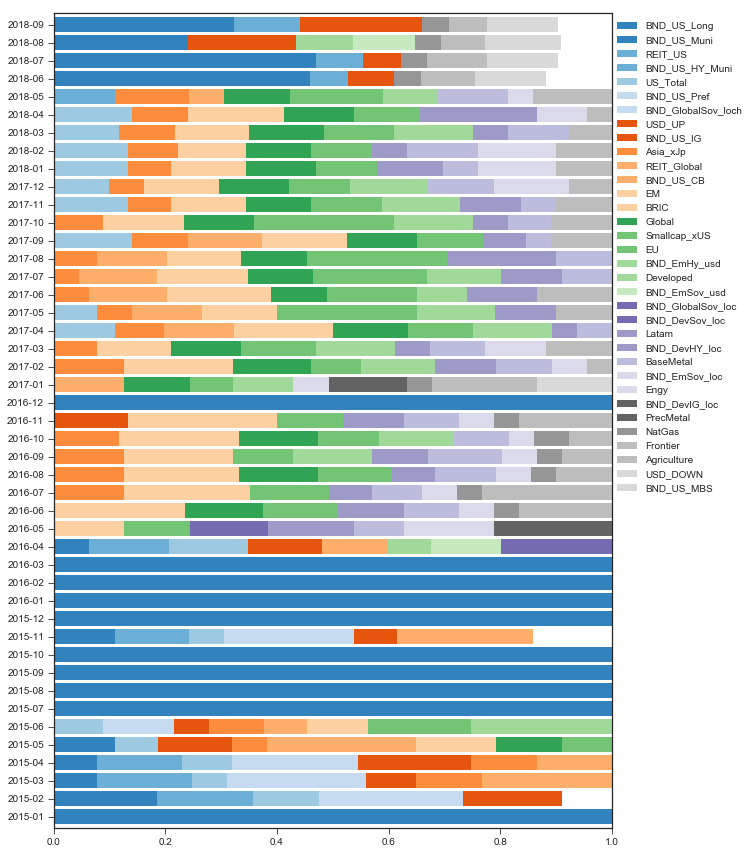

In [20]:
multiasset.plot_weight([2015, 2018])

# Global equity allocation model

In [21]:
geam = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    rebal_style='cum', 
    n_picks=10, 
    assets=setting.assets_global_eq, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,0,0,0], 
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1]), 
    #sig_dyn_m_backs=24, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_Interm', 
    start='2007-12-31', 
    losscut=0.05, 
    profitake_sigma=3, 
    rentry_sigma=2, 
)

HBox(children=(IntProgress(value=0, max=129), HTML(value='')))


30.95549201965332


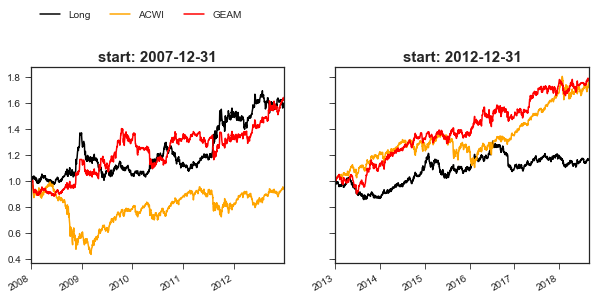

In [23]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum_multi_periods(strats, names=names, color=color, logy=False, separator=['2012-12-31'])

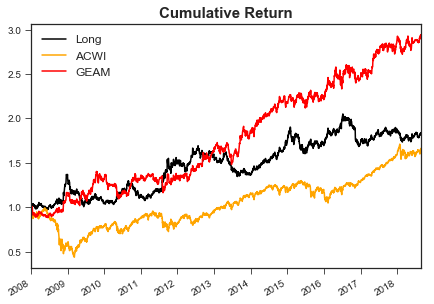

In [22]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

In [24]:
geam.get_stats().tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_US_Interm,1.53,2688,4.04,6.87,0.59,-10.40,4.72,6.21,0.69,-0.13,29.68,52.76,1.52,76.55
Indonesia,1.22,2688,1.87,31.21,0.06,-72.14,5.51,29.25,0.22,0.66,38.91,57.48,0.91,22.02
Austria,0.83,2688,-1.68,30.19,-0.06,-75.06,6.51,22.07,0.27,1.20,39.81,52.76,0.98,-161.31
BND_US_Long,1.82,2688,5.72,14.81,0.39,-26.58,5.51,14.10,0.34,-0.30,29.85,51.97,1.37,85.26
DualMomentum,2.91,2688,10.45,14.91,0.70,-22.02,11.49,14.55,0.83,0.13,8.49,55.91,1.48,95.73


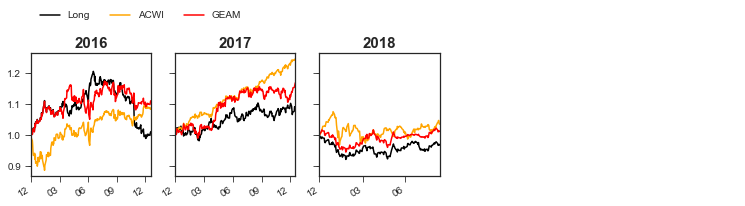

In [25]:
geam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

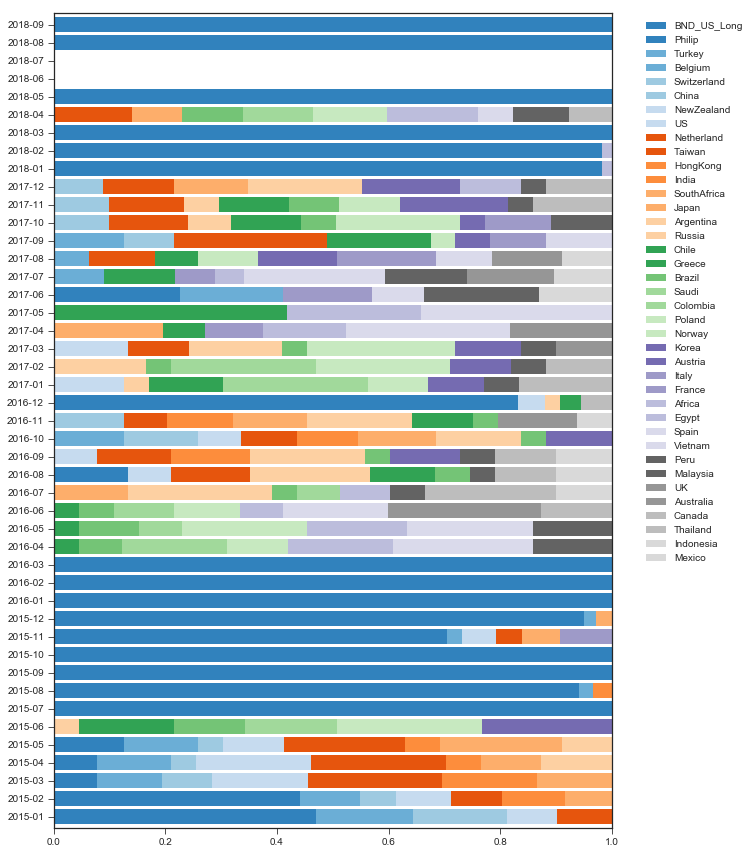

In [26]:
geam.plot_weight([2015, 2018])

# Global sector allocation model

In [82]:
gsam = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    rebal_style='cum', 
    n_picks=10, 
    assets=setting.assets_global_sector, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,0,0,0], 
    sig_w_dynamic=True, 
    sig_dyn_fwd=21*np.array([1]), 
    #sig_dyn_m_backs=24, 
    #sig_dyn_thres=0.0, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_Interm', 
    start='2007-12-31', 
    losscut=0.05,
    profitake_sigma=3, 
    rentry_sigma=2, 
)

HBox(children=(IntProgress(value=0, max=129), HTML(value='')))


34.99548578262329


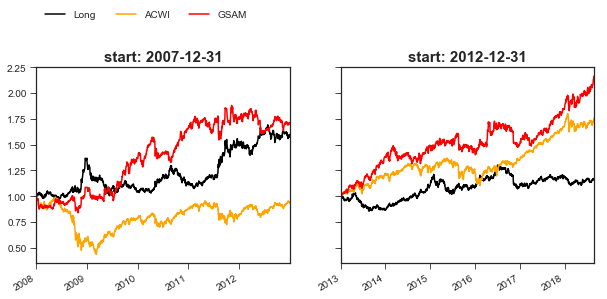

In [83]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'GSAM']
color = ['k', 'orange', 'r']

gsam.plot_cum_multi_periods(strats, names=names, color=color, logy=False, separator=['2012-12-31'])

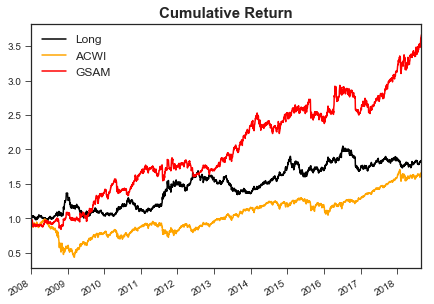

In [85]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'GSAM']
color = ['k', 'orange', 'r']

gsam.plot_cum(strats, names=names, color=color, logy=False)

In [84]:
gsam.get_stats().tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Gaming,1.13,2688,1.16,28.72,0.04,-74.11,15.90,21.75,0.74,0.92,31.45,54.33,0.98,-51.04
Insurance,2.19,2688,7.57,30.19,0.25,-71.62,13.43,15.05,0.84,1.17,17.92,64.57,0.81,35.77
Media,2.42,2688,8.58,23.00,0.37,-62.58,12.05,16.99,0.78,0.91,24.72,59.84,1.00,59.53
BND_US_Long,1.82,2688,5.72,14.81,0.39,-26.58,5.51,14.10,0.34,-0.30,29.85,51.97,1.37,85.26
DualMomentum,3.67,2688,12.85,16.18,0.79,-16.47,11.90,14.66,0.75,0.30,12.71,61.42,1.24,93.83


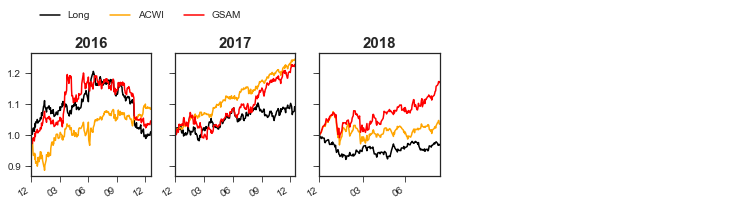

In [86]:
gsam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

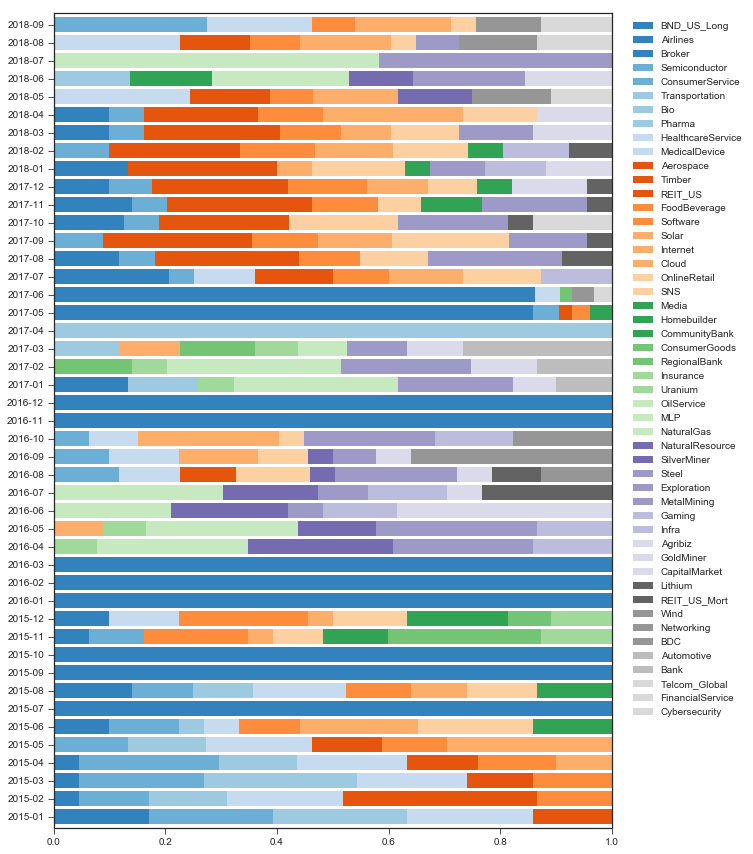

In [87]:
gsam.plot_weight([2015, 2018])

# Global bond allocation model

In [48]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import backtester_base as q_base
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
gbam = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    rebal_style='equal', 
    freq='1M', 
    n_picks=5, 
    assets=setting.assets_fi, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,0,0,0], 
    sig_w_dynamic=True, 
    sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_thres=0.1, 
    #sig_dyn_m_backs=12, 
    follow_trend=None, #(60,250), 
    follow_trend_market=None, #(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market='BND_US_Interm', #'BND_GlobalSov_loch', #'BND_US_AGG', 
    supporter='ACWI', 
    cash_equiv='BND_US_Long', 
    start='2007-12-31', 
    losscut=1.03, 
    profitake_sigma=30,
    rentry_sigma=20, 
)

HBox(children=(IntProgress(value=0, max=129), HTML(value='')))


23.607172966003418


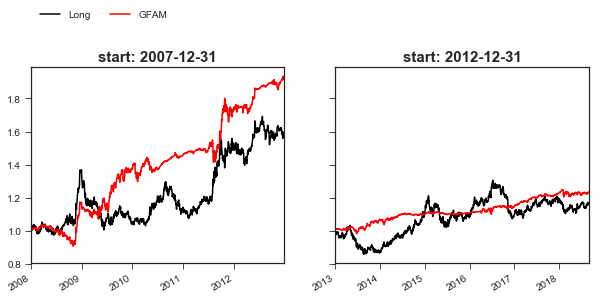

In [196]:
strats = ['BND_US_Long', 'DualMomentum']
names = ['Long', 'GFAM']
color = ['k', 'r']

gbam.plot_cum_multi_periods(strats, names=names, color=color, logy=False, separator=['2012-12-31'])

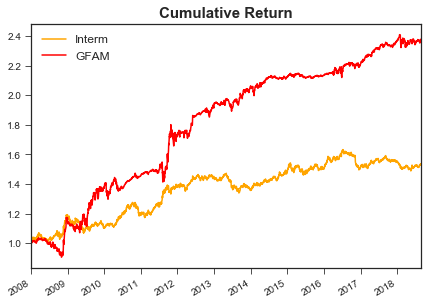

In [184]:
strats = ['BND_US_Interm', 'DualMomentum']
names = ['Interm', 'GFAM']
color = ['orange', 'r']

gbam.plot_cum(strats, names=names, color=color, logy=False)

In [90]:
gbam.get_stats().tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_US_Bankloan,1.54,2688,4.11,4.92,0.83,-32.43,3.49,3.30,1.60,0.07,17.22,63.78,1.01,77.00
BND_DevFloat_usd,1.15,2688,1.27,2.72,0.47,-7.30,1.42,0.85,1.34,0.01,14.80,78.74,0.56,86.84
BND_US_Muni,1.46,2688,3.58,5.30,0.68,-12.33,3.61,3.79,0.88,0.01,17.43,62.99,1.05,93.25
BND_US_IG,1.70,2688,5.06,8.41,0.60,-21.54,6.71,5.74,1.21,0.06,17.38,62.20,1.14,91.43
DualMomentum,2.37,2688,8.37,8.87,0.94,-12.50,6.46,5.09,1.10,0.14,1.60,65.35,1.46,85.51


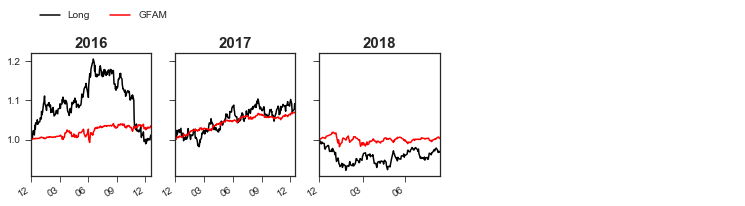

In [91]:
gbam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

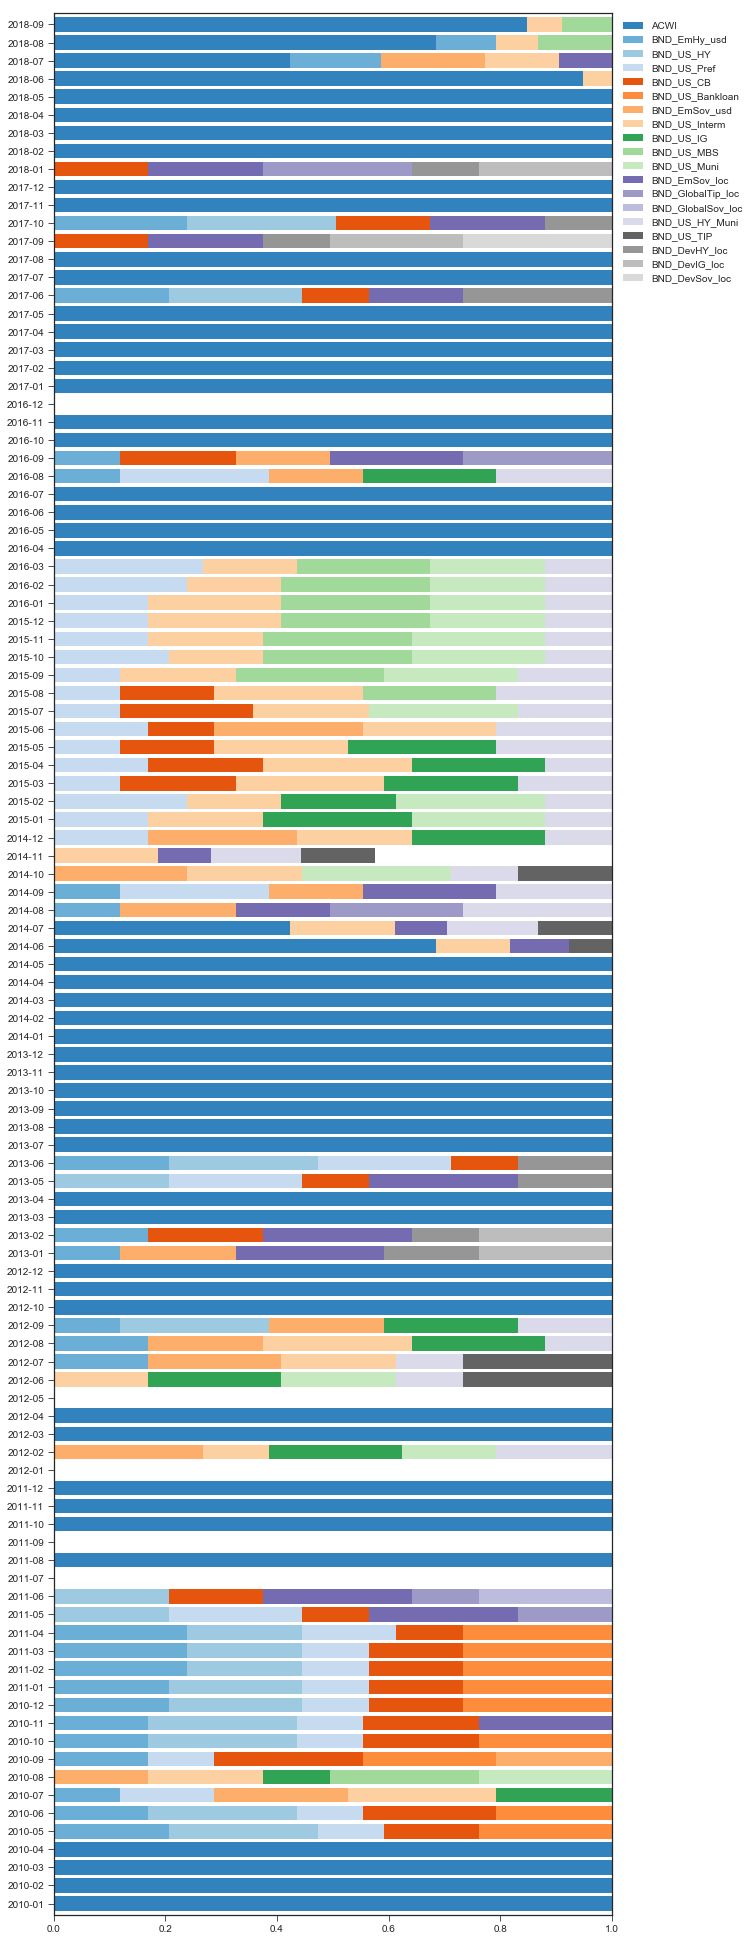

In [92]:
gbam.plot_weight([2010, 2018])

In [371]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Korea factor allocation model
여기서부터 calibration 다시 시작

In [335]:
kfam = q.Backtester(
    setting.base_params(db_kr), 
    w_type='inv_ranky2', # ranky2 가 더 잘나오긴 한다. ----
    rebal_style='equal', 
    freq='1M', 
    n_picks=5, 
    assets=setting.assets_kr_factor, #|setting.assets_us_factor2, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=True, 
    sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=12, 
    follow_trend=None, #(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='K200', 
    supporter='KTB10YL', 
    cash_equiv= 'KTB10Y', 
    #trade_assets=[('K200', {'K200L':0.5})], 
    start='2007-12-31', 
    losscut=0.05, 
    profitake_sigma=10, 
    rentry_sigma=2, 
)


5.834362745285034


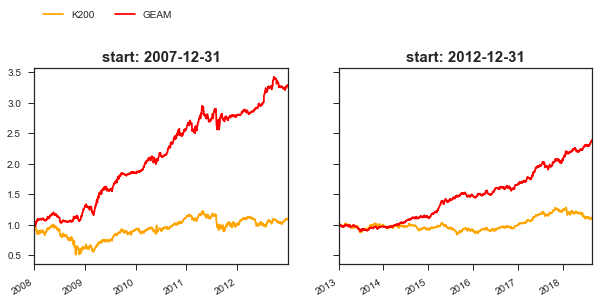

In [323]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum_multi_periods(strats, names=names, color=color, logy=False, separator=['2012-12-31'])

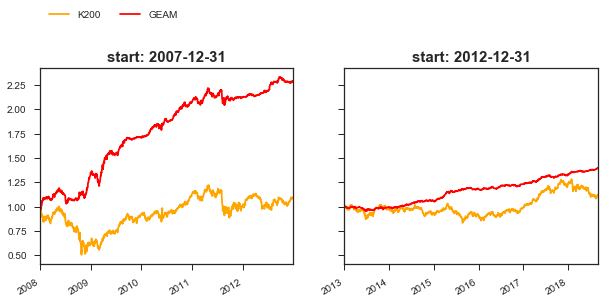

In [329]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum_multi_periods(strats, names=names, color=color, logy=False, separator=['2012-12-31'])

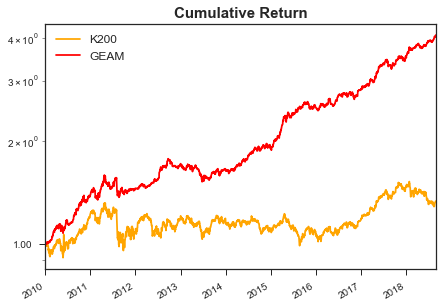

In [8]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=True, start='2009-12-31')

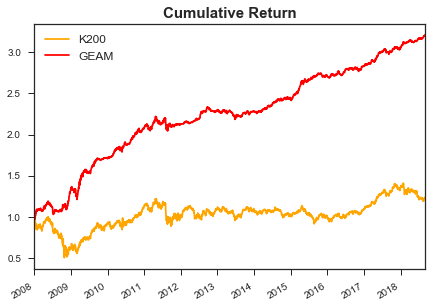

In [330]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=False)

In [5]:
kfam.get_stats().tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
HighDvd_kr,1.88,2767,5.87,15.26,0.38,-44.43,10.90,11.08,1.01,0.21,19.90,60.63,0.96,72.64
ACWI,1.64,2767,4.60,20.94,0.22,-56.41,11.04,15.39,0.73,1.00,24.82,60.63,0.88,23.18
K200,1.24,2767,1.93,20.75,0.09,-49.63,2.63,13.37,0.18,0.30,41.66,57.48,0.88,18.48
Contrarian_kr,1.57,2767,4.16,22.64,0.18,-60.07,7.16,15.11,0.53,0.31,32.17,59.06,0.92,60.01
DualMomentum,7.77,2767,20.36,11.04,1.84,-14.38,19.89,9.18,2.21,0.05,9.25,72.44,1.42,89.31


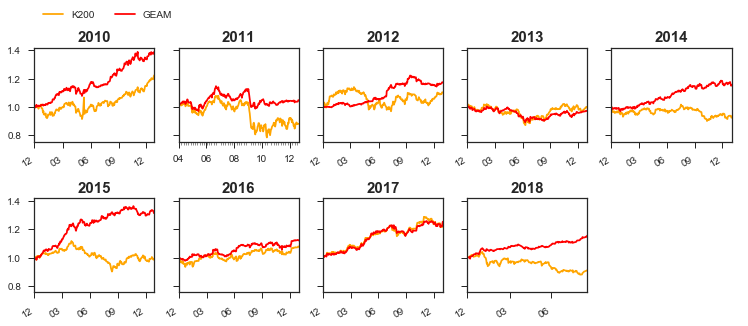

In [271]:
kfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2010))

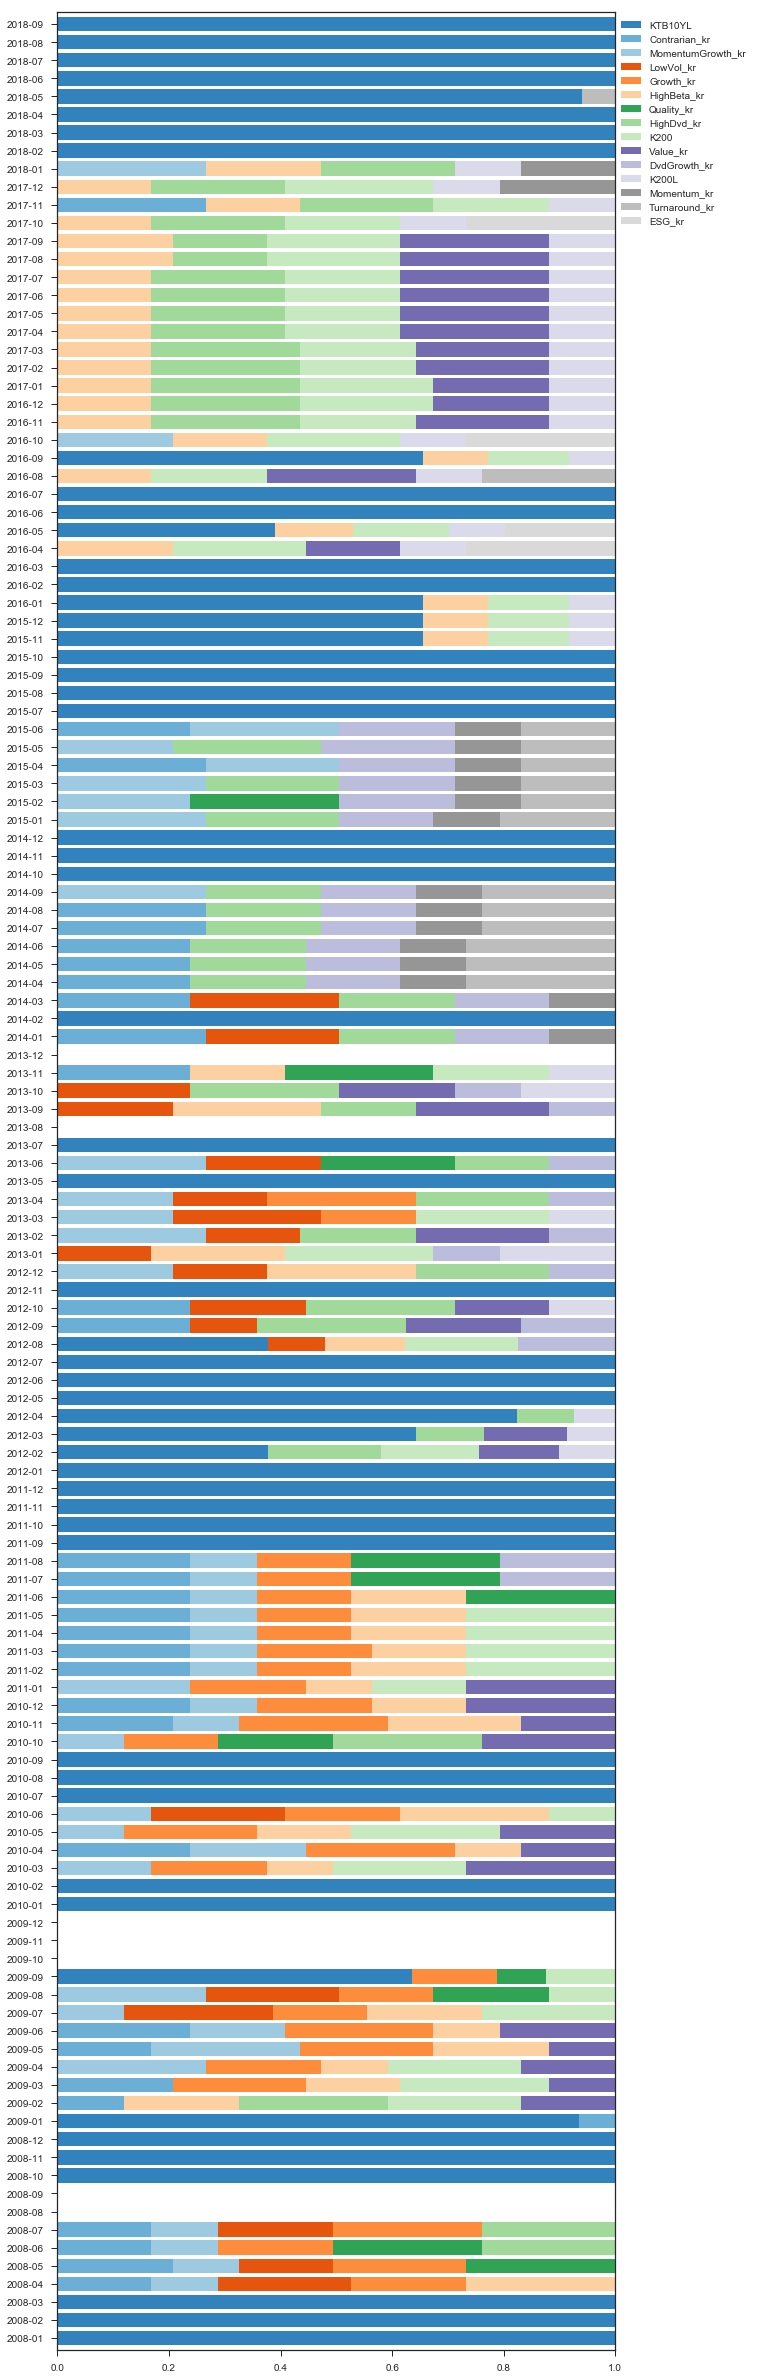

In [272]:
kfam.plot_weight([2003, 2018])

# Global factor allocation model

In [209]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
gfam = q.Backtester( 
    setting.base_params(db), 
    w_type='inv_ranky2', # ranky2 가 더 잘나오긴 한다. ----
    rebal_style='cum', 
    freq='1M', 
    n_picks=5, 
    assets=setting.assets_global_factor, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,0,0,0], 
    sig_w_dynamic=True, 
    sig_dyn_fwd=21*np.array([1]), 
    #sig_dyn_m_backs=12, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='ACWI', 
    supporter='KTB10YL', #'BND_US_Long', 
    cash_equiv= 'BND_US_Long', 
    start='2007-12-31', 
    losscut=1.05, 
    profitake_sigma=10, 
    rentry_sigma=20, 
)

HBox(children=(IntProgress(value=0, max=129), HTML(value='')))


25.194225549697876


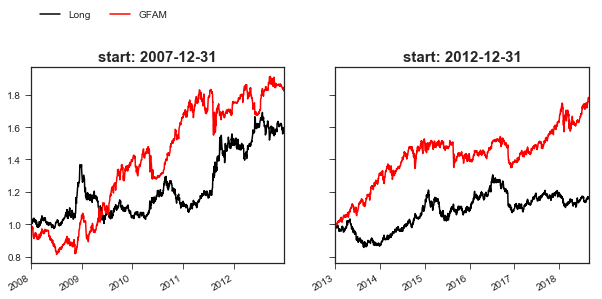

In [106]:
strats = ['BND_US_Long', 'DualMomentum']
names = ['Long', 'GFAM']
color = ['k', 'r']

gfam.plot_cum_multi_periods(strats, names=names, color=color, logy=False, separator=['2012-12-31'])

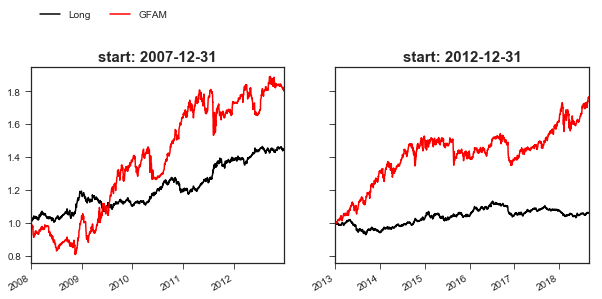

In [101]:
strats = ['BND_US_Interm', 'DualMomentum']
names = ['Long', 'GFAM']
color = ['k', 'r']

gfam.plot_cum_multi_periods(strats, names=names, color=color, logy=False, separator=['2012-12-31'])

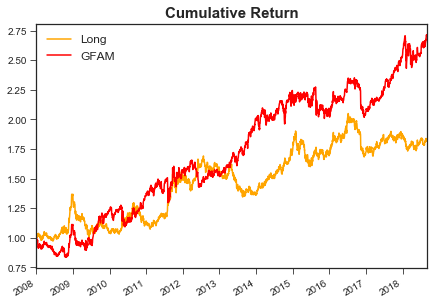

In [96]:
strats = ['BND_US_Long', 'DualMomentum']
names = ['Long', 'GFAM']
color = ['orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

# Advanced Dual Momentum

In [145]:
adm = q.Backtester( 
    setting.base_params(db), 
    w_type='inv_ranky2', # ranky2 가 더 잘나오긴 한다. ----
    rebal_style='cum', 
    freq='1M', 
    n_picks=1, 
    assets=setting.assets_adm, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,0,1], 
    sig_w_dynamic=False, 
    sig_dyn_fwd=21*np.array([1]), 
    #sig_dyn_m_backs=12, 
    follow_trend=None, #(20,60), 
    follow_trend_market=None, #(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market=None, #'ACWI', 
    supporter='BND_US_Long', 
    cash_equiv= 'BND_US_Interm', 
    start='2007-12-31', 
    losscut=1.05, 
    profitake_sigma=30, 
    rentry_sigma=20, 
)

HBox(children=(IntProgress(value=0, max=129), HTML(value='')))


22.06151580810547


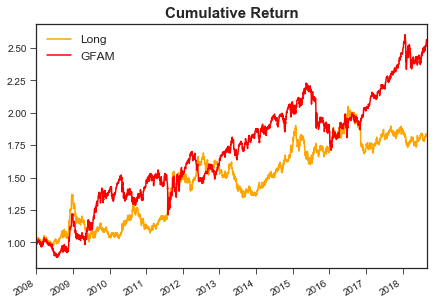

In [138]:
strats = ['BND_US_Long', 'DualMomentum']
names = ['Long', 'GFAM']
color = ['orange', 'r']

adm.plot_cum(strats, names=names, color=color, logy=False)

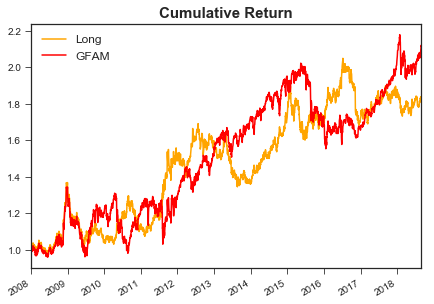

In [146]:
strats = ['BND_US_Long', 'DualMomentum']
names = ['Long', 'GFAM']
color = ['orange', 'r']

adm.plot_cum(strats, names=names, color=color, logy=False)

In [350]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [336]:
mix = q_base.BacktestComparator(setting.base_params(db), multiasset=multiasset, geam=geam, kfam=kfam, gsam=gsam, gfam=gfam)
mix.mix()

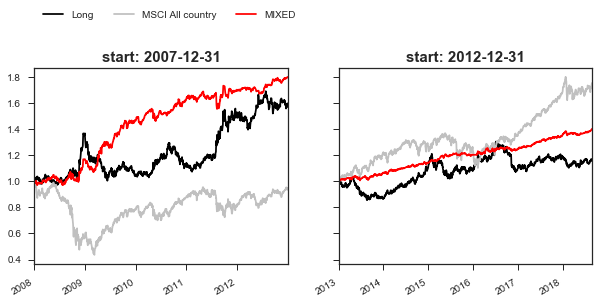

In [337]:
strats = ['BND_US_Long', 'ACWI', 'mixed']
names = ['Long', 'MSCI All country', 'MIXED']
color = ['k', 'silver', 'r']

mix.plot_cum_multi_periods(strats, names=names, color=color, logy=False, separator=['2012-12-31'])

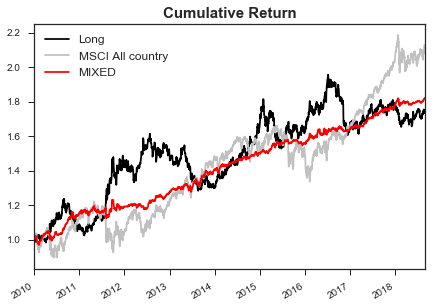

In [353]:
strats = ['BND_US_Long', 'ACWI', 'mixed']
names = ['Long', 'MSCI All country', 'MIXED']
color = ['k', 'silver', 'r']

mix.plot_cum(strats, names=names, color=color, logy=False, start='2009-12-31')

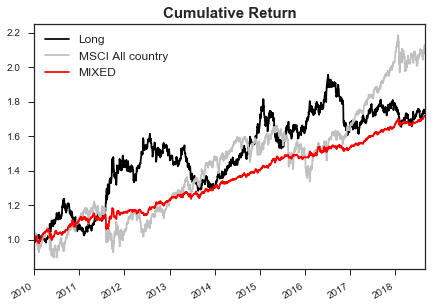

In [338]:
strats = ['BND_US_Long', 'ACWI', 'mixed']
names = ['Long', 'MSCI All country', 'MIXED']
color = ['k', 'silver', 'r']

mix.plot_cum(strats, names=names, color=color, logy=False, start='2009-12-31')

In [334]:
mix.get_stats(start='2009-12-31').tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
geam,1.59,2183,5.45,9.02,0.60,-15.20,6.21,7.46,0.80,0.19,7.19,59.22,1.20,92.20
kfam,1.87,2183,7.46,4.44,1.68,-7.97,6.74,3.63,1.92,0.04,9.51,77.67,1.07,88.52
gsam,1.78,2183,6.83,8.45,0.81,-10.74,5.21,7.41,0.70,0.30,13.55,63.11,1.20,90.42
gfam,1.41,2183,3.99,3.81,1.05,-5.93,3.79,3.33,1.10,0.07,5.12,63.11,1.48,94.90
mixed,1.78,2183,6.80,5.32,1.28,-9.08,6.22,4.24,1.51,0.15,0.00,70.87,1.28,95.81


In [330]:
rt = mix.cum.mixed.resample('M').ffill().pct_change()#.plot.bar()
rt[rt<-0.05]

2009-01-31   -0.060275
Freq: M, Name: mixed, dtype: float64

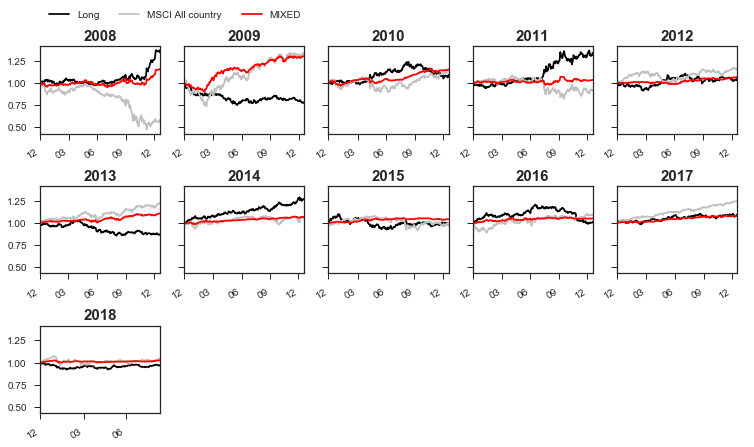

In [331]:
mix.plot_cum_yearly(strats, names=names, color=color)#, remove=range(2003,2013))